In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
parasitized_contrast = os.listdir('./Parasitized_enlarge/contrast/') 
uninfected_contrast = os.listdir('./Uninfected_enlarge/contrast/') 
data = []
labels = []


In [3]:
for positive_data in parasitized_contrast:
    if positive_data == "Thumbs.db":
        continue
    image = Image.open("./Parasitized_enlarge/contrast/" + positive_data)
    image = image.resize((64, 64))
    rotated30 = image.rotate(30)
    rotated60 = image.rotate(60)
    rotated90 = image.rotate(90)

    data.append(np.array(image))
    data.append(np.array(rotated30))
    data.append(np.array(rotated60))
    data.append(np.array(rotated90))
    labels.append(1)
    labels.append(1)
    labels.append(1)
    labels.append(1)

for negative_data in uninfected_contrast:
    if negative_data == "Thumbs.db":
        continue
    image = Image.open("./Uninfected_enlarge/contrast/" + negative_data)
    image = image.resize((64, 64))
    rotated30 = image.rotate(30)
    rotated60 = image.rotate(60)
    rotated90 = image.rotate(90)
    
    data.append(np.array(image))
    data.append(np.array(rotated30))
    data.append(np.array(rotated60))
    data.append(np.array(rotated90))
    labels.append(0)
    labels.append(0)
    labels.append(0)
    labels.append(0)

In [4]:
Data = np.array(data)
Labels = np.array(labels)

np.save('Data' , Data)
np.save('Labels' , Labels)
print('Data : {} | labels : {}'.format(Data.shape , Labels.shape))

Data : (110232, 64, 64, 3) | labels : (110232,)


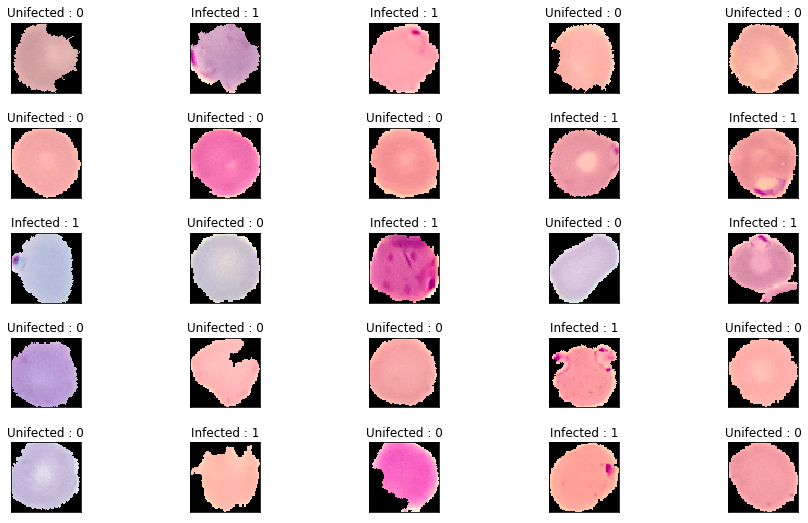

In [5]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(25):
    n += 1 
    r = np.random.randint(0 , Data.shape[0] , 1)
    plt.subplot(5 , 5 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(Data[r[0]])
    plt.title('{} : {}'.format('Infected' if Labels[r[0]] == 1 else 'Unifected' ,
                               Labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

In [6]:
from sklearn.utils import shuffle
Data, Labels = shuffle(Data, Labels)

In [7]:
Data = Data.astype(np.float32)
Data = Data / 255
Labels = Labels.astype(np.int32)

# Split Data

In [8]:
from sklearn.model_selection import train_test_split
ntrain = int(len(Data)*0.8)
X_test = Data[ntrain:]
y_test = Labels[ntrain:]
X_train, X_val, y_train, Y_val = train_test_split(Data[0:ntrain], Labels[0:ntrain], test_size=0.2, random_state = 40)

# Keras Model

In [9]:
import keras
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',optimizer = Adam(0.0001), metrics = ['accuracy'])


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 256)         295168    
__________

In [10]:

history = model.fit(X_train,y_train, validation_data=(X_val, Y_val),epochs=30,batch_size=100,verbose=True)
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 70548 samples, validate on 17637 samples
Epoch 1/30
70548/70548 [==============================] - 20s 291us/step - loss: 0.4764 - acc: 0.7710 - val_loss: 0.3050 - val_acc: 0.8713
Epoch 2/30
70548/70548 [==============================] - 15s 217us/step - loss: 0.3001 - acc: 0.8779 - val_loss: 0.2688 - val_acc: 0.8899
Epoch 3/30
70548/70548 [==============================] - 15s 217us/step - loss: 0.2616 - acc: 0.8972 - val_loss: 0.2350 - val_acc: 0.9051
Epoch 4/30
70548/70548 [==============================] - 16s 220us/step - loss: 0.2426 - acc: 0.9056 - val_loss: 0.2241 - val_acc: 0.9102
Epoch 5/30
70548/70548 [==============================] - 15s 220us/step - loss: 0.2265 - acc: 0.9127 - val_loss: 0.2224 - val_acc: 0.9143
Epoch 6/30
70548/70548 [==============================] - 15s 218us/step - loss: 0.2149 - acc: 0.9179 - val_loss: 0.2071 - val_acc: 0.9202
Epoch 7/30
70548/70548 [==============================] - 15s 219us/step - loss: 0.2070 - acc: 0.9215 - val_loss: 0.

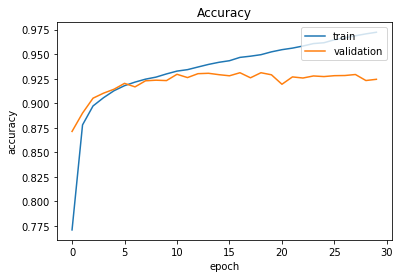

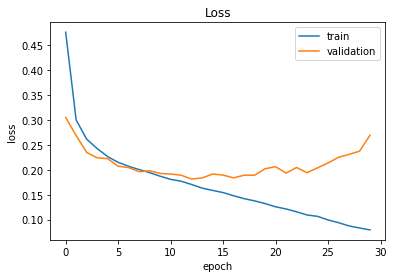

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

In [16]:
y_pred = model.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred).ravel() # tn, fp, fn, tp

array([10637,   418,  1250,  9742])

# TensorFlow Estimator

In [ ]:
def cnn_model_fn(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 64, 64, 3])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
  
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=128,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

    
    conv4 = tf.layers.conv2d(
        inputs=pool1,
        filters=256,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    # Dense Layer
    pool4 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2, padding = 'same')
    
    pool2_flat = tf.layers.flatten(pool4)

    dense1 = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1, units=128, activation=tf.nn.relu)
#     dropout = tf.layers.dropout(
#         inputs=dense2, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dense2, units=2)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
          return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [ ]:
# Create the Estimator
malaria_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn)

In [ ]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [ ]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=y_train,
    batch_size=100,
    num_epochs=20,
    shuffle=True)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_val},
    y=Y_val,
    num_epochs=2,
    shuffle=False)
train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn)
tf.estimator.train_and_evaluate(malaria_classifier, train_spec, eval_spec)

In [ ]:
# Evaluate the model and print results

eval_results = malaria_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)